# RANS ABL Mesh mapping
## Geometric growth blended with constant cell size

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath
import math

## Blended mapping function 

We're going to build the mapping function as a blend between two functions $x_{geom}$ and $x_{const}$:  

$$
x(\xi) = x_{geom}(\xi) (1-h(\xi)) + h(\xi) x_{const}(\xi)
$$

where the blend function $h(\xi)$ is defined as  

$$
h(\xi, \xi_T, W) = \frac{1}{2} \left( 1 + \tanh \left( \frac{\xi-\xi_T}{W} \right) \right)
$$

and depends on the transition location $\xi_T$ and width W.  

$$
\frac{d x}{d \xi} = (1-h) x'_{geom} - h' x_{geom} + h x'_{const} + h' x_{const}
$$

### Geometry growth mapping function  

The geometric growth function $x_{geom}$ is defined as :  

$$
x_{geom}(\xi) = \frac{\Delta_0}{r}  \frac{1-r^{\xi+1}}{1-r} - \frac{\Delta_0}{r}
$$

With the first cell height $\Delta_0$ and stretch rate $r$>1 provided by the user.  

The inverse of this function is
$$
\xi_{inv}(x) = \frac{\ln \left( 1- (x-\Delta_0/r) \frac{r (1-r)}{\Delta_0} \right)}
{\ln (r)}
$$

The derivative of this function is:
$$
\frac{d x_{geom}}{d\xi} = \frac{\Delta_0}{r (r-1)} r^{\xi-1} \log(r)
$$

### Constant cell size mapping function  

$$
x_{const} = s(\xi-\xi_0) + L_{match}
$$

slope $s$, offset $\xi_0$, and match height $L_{match}$.

To set up the constants in $x_{const}$, there are two options:
1.  We can compute the $\xi$ that would correspond to $L$ input by the user:

$$
\xi_L = \textrm{int}\{ x_{inv}(L, \delta_0, r) \}
$$

2.  We can compute the $\xi$ that would correspond to $\Delta_{max}$ input by the user:

$$
\xi_L = \textrm{floor} \left[ \frac{\ln (\Delta_{max} r^2/\Delta_0)}{\ln r} \right] - 1
$$

We'll set the offset $\xi_0$=$\xi_L$. Because $\xi_L$ has been rounded to the nearest integer, we'll compute $L_{match}$ at $\xi_L$

$$
L_{match} = x_{geom}(\xi_L, \delta_0, r)
$$

And the slope will be the cell size at $\xi_L$: 

$$
s =  x_{geom}(\xi_L, \delta_0, r) -  x_{geom}(\xi_L-1, \delta_0, r)
$$

The derivative of $x_{const}$ is

$$
\frac{d x_{const}}{d\xi} = s
$$

In [2]:

def plotgrid(ax, xivec, coordfunc, *args, **kwargs):
    for xi in xivec:
        x = coordfunc(xi, *args)
        #print(x)
        ax.axhline(x,**kwargs)
    return

def printgrid(xivec, coordfunc, *args):
    print('%-4s %8s %8s %s'%('xi','real x','cellsize','stretching'))
    for i, xi in enumerate(xivec):
        x = coordfunc(xi, *args)
        cellsize = 0.0 if i==0 else x - coordfunc(xivec[i-1], *args)
        sratio   = 0.0 if i<2  else cellsize/(coordfunc(xivec[i-1], *args)-coordfunc(xivec[i-2], *args))
        print('%-4i %8.4f %8.4f %8.4f'%(xi, x, cellsize, sratio))

In [3]:
hblend  = lambda xi, xiT, W: 0.5*(1+np.tanh((xi-xiT)/W))
dhblend = lambda xi, xiT, W: 0.5/W*(mpmath.sech((xi-xiT)/W))**2

xgeom   = lambda xi, delta0, r: delta0*(1-r**(xi+1))/(1-r)/r - delta0/r
dxgeom  = lambda xi, delta0, r: delta0/r/(r-1)*np.log(r)*r**(xi-1)

xconst  = lambda xi, slope, xi0, L: slope*(xi - xi0) + L 
dxconst = lambda xi, slope, xi0: slope*(xi)

xiinverse = lambda x, delta0, r: np.log(1.0 - (x-delta0/r)*r*(1.0-r)/delta0)/np.log(r)

xideltamax = lambda deltamax, delta0, r: np.log(deltamax/delta0*r*r)/np.log(r)

def xcoord(xi, delta0, r, L):
    # Get the match xi
    xiL  = int(xiinverse(L, delta0, r))
    Lmatch = xgeom(xiL, delta0, r)
    # Get the slope
    dxiL = xgeom(xiL, delta0, r) - xgeom(xiL-1, delta0, r)
    
    #print('match = ',xiL)
    #print('slope = ',dxiL)
    W  = 0.1
    h  = hblend(xi, xiL, W)
    xg = xgeom(xi, delta0, r)
    xc = xconst(xi, dxiL, xiL, Lmatch)
    #print(xc)
    return xg*(1.0-h) + h*xc

def xcoord_deltamax(xi, delta0, r, deltamax):
    # Get the match xi
    xiL  = math.floor(xideltamax(deltamax, delta0, r))-1
    Lmatch = xgeom(xiL, delta0, r)
    # Get the slope
    dxiL = xgeom(xiL, delta0, r) - xgeom(xiL-1, delta0, r)
    
    #print('match = ',xiL)
    #print('slope = ',dxiL)
    W  = 0.1
    h  = hblend(xi, xiL, W)
    xg = xgeom(xi, delta0, r)
    xc = xconst(xi, dxiL, xiL, Lmatch)
    #print(xc)
    return xg*(1.0-h) + h*xc

In [4]:
Nxi    = 20
xi     = np.linspace(0,Nxi-1,Nxi)
delta0 = 0.1
r      = 1.1
xmatch = 1.0

deltamax = 0.25

#print(coord(0, delta0, r))
#print(coord(1, delta0, r))
#print(xi[0],delta0*((r**0) - r))

#printgrid(xi, xcoord, delta0, r, xmatch)
printgrid(xi, xcoord_deltamax, delta0, r, deltamax)
print()
print(xideltamax(0.177, delta0, r))

xi     real x cellsize stretching
0      0.0000   0.0000   0.0000
1      0.1000   0.1000   0.0000
2      0.2100   0.1100   1.1000
3      0.3310   0.1210   1.1000
4      0.4641   0.1331   1.1000
5      0.6105   0.1464   1.1000
6      0.7716   0.1611   1.1000
7      0.9487   0.1772   1.1000
8      1.1436   0.1949   1.1000
9      1.3579   0.2144   1.1000
10     1.5937   0.2358   1.1000
11     1.8295   0.2358   1.0000
12     2.0653   0.2358   1.0000
13     2.3011   0.2358   1.0000
14     2.5369   0.2358   1.0000
15     2.7727   0.2358   1.0000
16     3.0085   0.2358   1.0000
17     3.2443   0.2358   1.0000
18     3.4801   0.2358   1.0000
19     3.7159   0.2358   1.0000

7.990750912000987


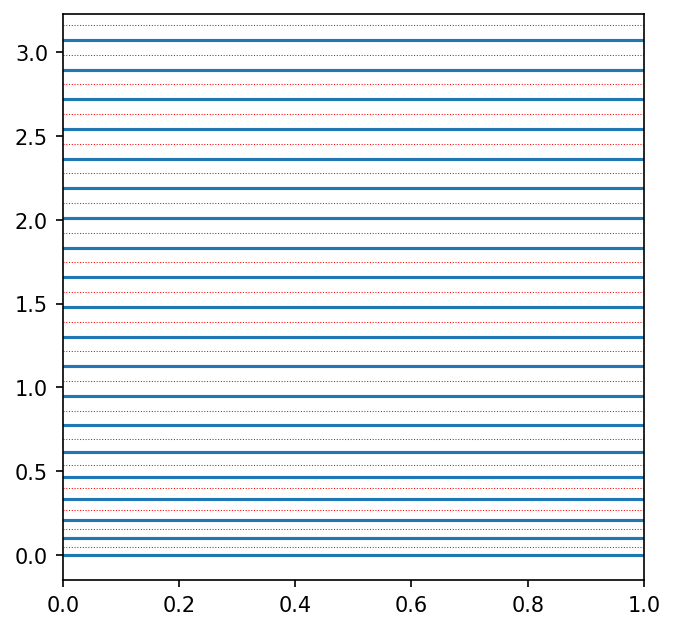

In [5]:
#Plot the grid
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
plotgrid(ax, xi, xcoord, delta0, r, xmatch)
plotgrid(ax, xi+0.5, xcoord, delta0, r, xmatch, color='r', ls=':', linewidth=0.50)